In [1]:
import torch
import matplotlib.pyplot as plt
import non_local_boxes
import numpy as np
from IPython.display import clear_output   # in order to clear the print output
import time

# Sugar coating for reloading
%matplotlib inline
%load_ext autoreload
%autoreload 2

# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')   # in ordert to have unblurred pictures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Definitions

In [2]:
M1 = torch.zeros(32, 32)
for i in range(32):
    M1[i,i]=1
M1[0,0]=0.5
M1[0,1]=0.5
M1[1,0]=0.5
M1[1,1]=0.5

M2 = torch.zeros(32, 32)
for i in range(32):
    M2[i,i]=1
M2[8,8]=0.5
M2[8,9]=0.5
M2[9,8]=0.5
M2[9,9]=0.5

M3 = torch.zeros(32, 32)
for i in range(32):
    M3[i,i]=1
M3[2,2]=0.5
M3[2,3]=0.5
M3[3,2]=0.5
M3[3,3]=0.5

M4 = torch.zeros(32, 32)
for i in range(32):
    M4[i,i]=1
M4[10,10]=0.5
M4[10,11]=0.5
M4[11,10]=0.5
M4[11,11]=0.5

M5 = torch.zeros(32, 32)
for i in range(32):
    M5[i,i]=1
M5[4,4]=0.5
M5[4,5]=0.5
M5[5,4]=0.5
M5[5,5]=0.5

M6 = torch.zeros(32, 32)
for i in range(32):
    M6[i,i]=1
M6[12,12]=0.5
M6[12,13]=0.5
M6[13,12]=0.5
M6[13,13]=0.5

M7 = torch.zeros(32, 32)
for i in range(32):
    M7[i,i]=1
M7[6,6]=0.5
M7[6,7]=0.5
M7[7,6]=0.5
M7[7,7]=0.5

M8 = torch.zeros(32, 32)
for i in range(32):
    M8[i,i]=1
M8[14,14]=0.5
M8[14,15]=0.5
M8[15,14]=0.5
M8[15,15]=0.5

In [3]:
def projected_wiring(W):  # W is a 32xn tensor
    W = torch.maximum(W, torch.zeros_like(W))  # it outputs the element-wise maximum
    W = torch.minimum(W, torch.ones_like(W))   # similarly for minimum

    T1 = (torch.abs(W[0,:]-W[1,:]) <= torch.abs(W[8, :] - W[9, :]))
    W = T1*torch.tensordot(M1, W, dims=1) + torch.logical_not(T1)*torch.tensordot(M2, W, dims=1)
    
    T2 = (torch.abs(W[2,:]-W[3,:]) <= torch.abs(W[10, :] - W[11, :]))
    W = T2*torch.tensordot(M3, W, dims=1) + torch.logical_not(T2)*torch.tensordot(M4, W, dims=1)

    T3 = (torch.abs(W[4,:]-W[5,:]) <= torch.abs(W[12, :] - W[13, :]))
    W = T3*torch.tensordot(M5, W, dims=1) + torch.logical_not(T3)*torch.tensordot(M6, W, dims=1)

    T4 = (torch.abs(W[6,:]-W[7,:]) <= torch.abs(W[14, :] - W[15, :]))
    W = T4*torch.tensordot(M7, W, dims=1) + torch.logical_not(T4)*torch.tensordot(M8, W, dims=1)

    return W

In [15]:
def gradient_descent(P, Q, learning_rate = 0.01, nb_iterations = 400, tolerance=1e-6):
    m = non_local_boxes.evaluate.nb_columns
    external_grad = torch.ones(m)
    W = non_local_boxes.utils.random_wiring(m)
    for _ in range(nb_iterations):
        Wold = W
        non_local_boxes.evaluate.phi_flat(W, P, Q).backward(gradient=external_grad)
        W = projected_wiring(W + learning_rate*W.grad).detach() 
        if (torch.max(torch.abs(W-Wold)) < tolerance):   return W
        W.requires_grad=True
    return W

# Histogram

In [16]:
PR = non_local_boxes.utils.PR
SR = non_local_boxes.utils.SR
I = non_local_boxes.utils.I

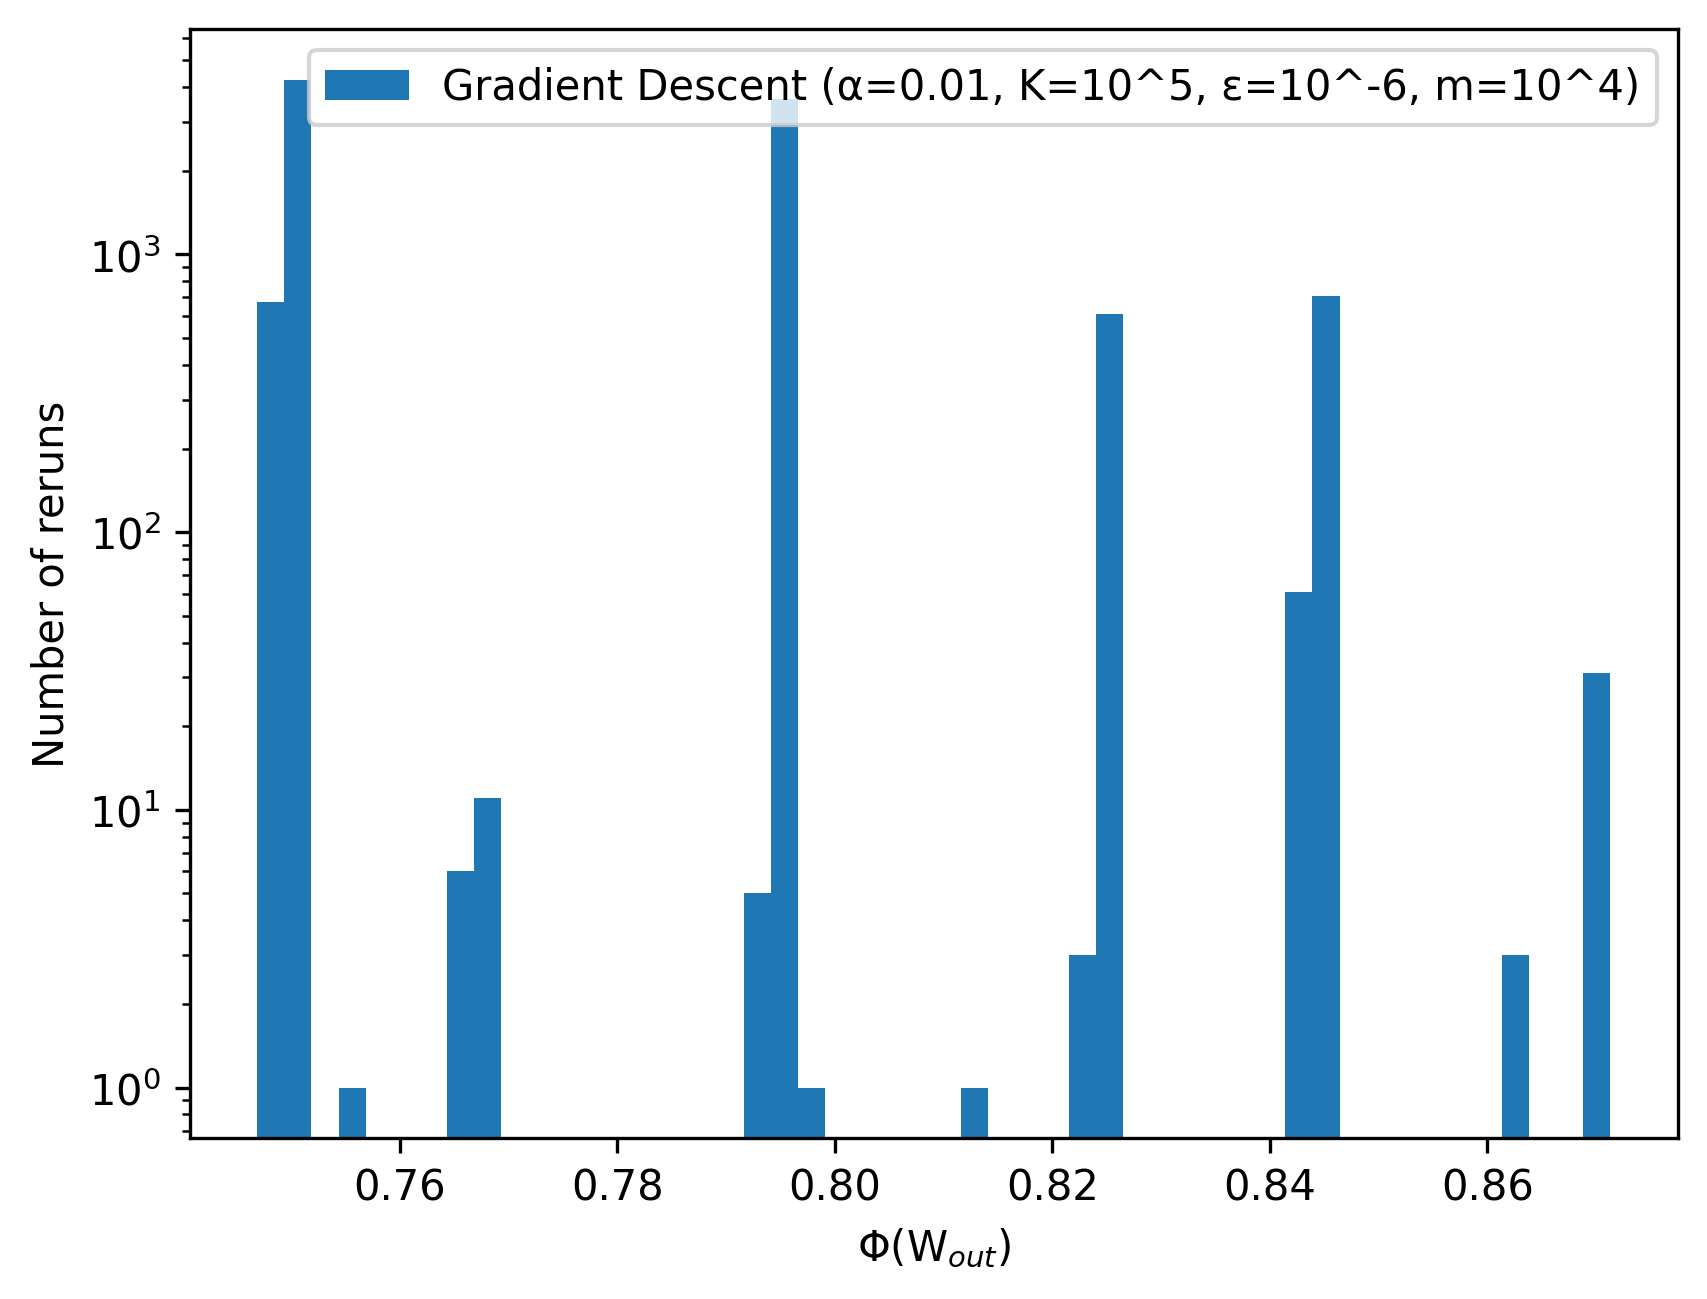

In [41]:
p=0.39
q=0.6
P = p*PR +q*SR + (1-p-q)*I
BoxProduct = non_local_boxes.evaluate.phi_flat

m = non_local_boxes.evaluate.nb_columns
alpha = 0.01
K=int(1e5)
epsilon=1e-6

W = gradient_descent(
    P=P,
    Q=P,
    learning_rate=alpha,
    nb_iterations=K,
    tolerance=epsilon
)
histogramGD = BoxProduct(W, P, P).tolist()

#plt.hist(histogramGD, bins=50, label="Gradient Descent (p="+str(p)+", q="+str(q)+", α="+str(alpha)+", K="+str(K)+", m=10^"+str(int(np.log10(m)))+", ε=10^"+str(int(np.log10(epsilon)))+")")
plt.hist(histogramGD, bins=50, label="Gradient Descent (α="+str(alpha)+", K=10^"+str(int(np.log10(K)))+", ε=10^"+str(int(np.log10(epsilon)))+", m=10^"+str(int(np.log10(m)))+")")
#plt.xlabel("CHSH-value")
plt.xlabel("$\Phi(\mathsf{W}_{{out}})$")
plt.ylabel("Number of reruns")
plt.yscale("log")
plt.legend()
#plt.title("Histogram of the different results with a random initialization (with $\mathbf{P}=(\mathbf{PR}+\mathbf{SR})/2$, total: "+str(N)+" occurences)")
plt.show()

In [49]:
for j in range(len(histogramGD)):
    print(str(histogramGD[j])+",")

0.7499573230743408,
0.7964582443237305,
0.7966035604476929,
0.7962557077407837,
0.7960366010665894,
0.75,
0.7499733567237854,
0.7966233491897583,
0.7962985038757324,
0.7962697148323059,
0.75,
0.7499970197677612,
0.7475469708442688,
0.75,
0.8449999094009399,
0.7963390946388245,
0.75,
0.7966298460960388,
0.7959930300712585,
0.796445369720459,
0.7965194582939148,
0.75,
0.7965517044067383,
0.796233057975769,
0.75,
0.7960205078125,
0.7492483258247375,
0.7966040968894958,
0.747577965259552,
0.7499855756759644,
0.7498223781585693,
0.75,
0.7961767911911011,
0.7964626550674438,
0.7497392296791077,
0.7960125207901001,
0.7965611219406128,
0.7960451245307922,
0.7499479651451111,
0.7499598264694214,
0.8712874054908752,
0.7965406775474548,
0.7960772514343262,
0.7958780527114868,
0.75,
0.75,
0.7499925494194031,
0.7961488962173462,
0.7499830722808838,
0.8449999094009399,
0.7499880790710449,
0.7960599660873413,
0.7492867112159729,
0.7488541603088379,
0.75,
0.7499370574951172,
0.7965856194496155,
0.7960

# Line Search

$$
\left\{
\begin{array}{l}
    \alpha^*_k = \argmax_\alpha \phi(x_k + \alpha \nabla \phi(x_k))\\
    x_{k+1}= \texttt{proj}(x_k + \alpha^*_k \nabla \phi(x_k))
\end{array}
\right.
$$

In [ ]:
def line_search_with_resets(P, Q, learning_rate = 2, nb_iterations = 40, tolerance=1e-6):
    m = non_local_boxes.evaluate.nb_columns
    phi_flat = non_local_boxes.evaluate.phi_flat
    W = non_local_boxes.utils.random_wiring(m)
    Gains = None
    step_damping = torch.ones([m])
    for _ in range(nb_iterations):
        # line search:
        Gains_old = Gains
        Gains = phi_flat(W, P, Q) # a vector of m elements
        if Gains_old is not None:
            mask = 0.0 + (Gains<Gains_old)
            step_damping  -= 0.5*step_damping*mask
            W = torch.t(mask[:, None]*torch.t(W_old) + (1-mask[:, None])*torch.t(W)).detach()
            W.requires_grad=True
            Gains = phi_flat(W, P, Q)
        G = torch.sum(Gains)
        G.backward()
        dG = W.grad
        # print(torch.mean(learning_rate*dG))
        W_old = W
        # print(float(non_local_boxes.evaluate.phi_flat(W, P, Q)))

        # gradient descent:
        W = projected_wiring(W + learning_rate*torch.t(step_damping[:,None]*torch.t(dG))).detach()  
        if (torch.norm(W_old-W) <= tolerance):   return W
        W.requires_grad=True
    return W

----

In [66]:
def reorder_list(L, phi):
    j=0
    while j<len(L):
        if j!=0 and phi[L[j-1]]<phi[L[j]]:
            L[j-1],L[j]=L[j],L[j-1]
            j-=2
        j+=1
    return L

In [68]:
L=[0,1,2,3]
phi=[0.1, 0.3, 0, 10]
L = reorder_list(L, phi)
print([phi[k] for k in L])

[10, 0.3, 0.1, 0]


In [ ]:
def select_best_columns(W, P, Q, integer):
    # L is the list of the "best" indexes of the columns of W
    # At the begining, we take the first indexes of W
    # We will change the list L by comparing the value at the other indexes
    # When we add a term to L, we also remove the "worst" one, and we re-order the list L
    L = range(integer)
    # phi is the list of values:
    phi= non_local_boxes.evaluate.phi_flat(W,P,Q).tolist()
    # we re-order the list L:
    L = reorder_list(L, phi)
    for i in range(integer,non_local_boxes.evaluate.nb_columns):
        if phi[i]>phi[L[-1]]:
            L[-1]=i # we remove and replace the worst index




    return W



def line_search_with_resets(P, Q, LS_iterations, K_reset, chi, epsilon=1e-6):
    m = non_local_boxes.evaluate.nb_columns
    phi_flat = non_local_boxes.evaluate.phi_flat
    W = non_local_boxes.utils.random_wiring(m)
    external_grad = torch.ones(m)
    
    for j in range(int(1/chi)):
        for _ in range(K_reset):
            # line search 
            phi_flat(W, P, Q).backward(gradient=external_grad)
            Wgrad = W.grad
            alpha = torch.ones(m)
            for _ in range(LS_iterations):
                Gains = phi_flat(W, P, Q)
                Gains_new = phi_flat(W + alpha*Wgrad, P, Q)
                mask = 0.0 + (Gains>Gains_new)
                alpha = 0.5*mask*alpha + 1.7*(1-mask)*alpha
            W = projected_wiring(W + alpha*Wgrad)
        W = select_best_columns(W, P, Q, int(j*m*chi))




In [59]:
A=torch.tensor([1,2,3])
B=torch.tensor([4,0,6])
mask = 0.0+(A<B)
print(mask*2-3*(1-mask))

tensor([ 2., -3.,  2.])


In [61]:
W=non_local_boxes.utils.W_BS09(non_local_boxes.evaluate.nb_columns)
non_local_boxes.evaluate.phi_flat(W,PR,PR).tolist()

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0